# INP concentration and Background subtraction (ACAO)
**Erin Raif, Oct 2022**

*Based on work of Sarah Barr*

Apologies for mess, was written a long time ago!

Folder structure for INP data: top level, individual days, individual runs

In [1]:
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # deal with div by 0

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Function definitions

In [2]:
def get_all_filters(folder):
    """Get all filter csvs. 
    Folder structure:
    top-level/dates/invididual runs/data

    Parameters
    ----------
    folder: string
        Parent folder containing all INP data

    Returns
    -------
    list of strings
        csv names of runs
    list of strings
        csv names of blanks
    list of strings
        dates of runs
    """
    folders = glob(folder + '/*')
    dates = []
    runs = []
    blanks = []
    for f in folders:
        if f[-6:].isnumeric():
            dates.append(f)
    for d in dates:
        for g in glob(d + '/*'):
            if len(glob(g+'/temps*')) == 1:
                r = glob(g+'/temps*')[0]
                if 'run' in r.lower():
                    runs.append(r)
                else:
                    blanks.append(r)
    return runs, blanks, dates

In [3]:
def fraction_frozen(csv):
    """Get fraction frozen from a CSV file
    
    Adapted from S. Barr.

    Parameters
    ----------
    csv: string
        Return csv name as a string

    Returns
    -------
    numpy array
        temperatures droplets froze at
    fraction frozen
        fraction of droplets frozen at each temperature
    """
    temps = np.genfromtxt(csv)
    temps.sort()
    ndrops = len(temps)
    temps = temps[::-1]
    ffs = np.sort(np.linspace(1,ndrops,ndrops)/float(ndrops))
    return temps, ffs

## $k(T)$, the differential nucleus spectrum
This is the number of sites active within a given temperature interval. Intervals should be chosen to avoid large numbers of bins having zero counts. $k(T)$ can be calculated for both the background and the run, so this is where subtraction must happen.

Error on the backgrounds is a simple mean of all background runs - worth noting that it may be worth comparing lab blanks to aircraft handling blanks at a later date.
Error on single runs comes from the Poisson distribution.

$$ k(T) = -\frac{1}{V_{d} \Delta T}\ln{\left(1-\frac{\Delta N}{n(T)}\right)} $$

$V_{d}$ droplet volume, $\Delta T$ temperature bin width, $\Delta N$ no. droplets frozen in, $n(T)$ no. unfrozen droplets at T

In [4]:
def calculate_single_kT(csv, T_range, ax=None, dT=1, v_d=0.002, **kwargs):
    """Calculate k(T) from a filter data CSV.

    Parameters
    ----------
    csv: string
        CSV name and location as string
    T_range: numpy array
        temperature interval bounds
    dT: float (default value 0.001)
        temperature interval
    v_d: float (default value 0.001)
        volume of droplet (ml)
    ax: matplotlib axes (optional)
        Axes to plot individual k(T) results on
    **kwargs:
        Matplotlib keyword arguments if modifications to default plotting are wanted

    Returns
    -------
    pandas categorical
        counts of droplets frozen in each temperature interval
    pandas categorical
        k(T) for droplets associated with each temperature interval
    """
    temps, ffs = fraction_frozen(csv)

    # Bin data according to no. droplets frozen in T-interval
    binned_T = pd.cut(temps, T_range)
    counts = pd.value_counts(binned_T).sort_index(ascending=False)

    # Calculate number of drops unfrozen n(T) at each step.
    nt = counts[::-1].cumsum()[::-1]
    ndrops = np.max(nt)

    # Adjust temperatures to start of bin
    temps = counts.index.categories.right[::-1]

    # Calculate k(T) and set values where n(T) is 0.
    kt = (-(1/(v_d*dT))) * (np.log(1-(counts/nt)))
    idx = np.where(kt == np.inf)
    kt.iloc[idx[0][0]] = np.nan
    if ax != None:
        if kwargs == {}:
            ax.plot(temps, kt, marker='o', linestyle=' ',
                    markersize=3, color='darkgray', label='_nolegend_')
        else:
            ax.plot(temps, kt, **kwargs)
    return counts, kt

In [5]:
def calculate_mean_kT(csvs, T_range, dT=1, v_d=0.002, plot=True, **kwargs):
    """Calculate mean k(T) from multiple filter data CSVs.
    Used for background data.

    Parameters
    ----------
    csvs: list of strings
        list of CSV name and location as strings
    min_T: float (default value -35)   
        lowest temperature for binning data (deg C)
    max_T: float (default value -5)
        greatest temperature for binning data (deg C)
    v_d: float (default value 0.001)
        volume of droplet (ml)
    dT: float (default value 1)
        temperature interval size (deg C)
    plot: bool (default value True)
        Plot k(T)
    **kwargs:
        Matplotlib keyword arguments if modifications to default plotting are wanted

    Returns
    -------
    pandas dataframe
        k(T) for all runs in all temperature intervals

    Optional returns
    ----------------
    matplotlib figure
        figure for plots
    matplotlib axes
        axes for plots

    """
    counts_all = []
    kt_all = []

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
        ax.set_yscale('log')
        ax.set_xlabel('T ($^{o}$C)')
        ax.set_ylabel('k(T) (cm$^{-3}$ $^{o}$C$^{-1}$)')

    for csv in csvs:
        counts, kt = calculate_single_kT(csv, T_range, ax, **kwargs)
        counts_all.append(counts)
        kt_all.append(kt)

    temps = counts_all[0].index.categories.right[::-1]
    # Make dataframe of k(T) values for all bins and calculate mean and std_dev
    df = pd.DataFrame()
    df = pd.concat(kt_all, axis=1)
    df['mean'] = mean = df.mean(axis=1)
    df['std'] = std = df.std(axis=1)

    if plot:
        ax.errorbar(temps, mean, yerr=std, marker='o', markersize=2,
                    color='green', capsize=2, elinewidth=1.25, label='Mean background')
        ax.legend()
        fig.tight_layout()
        return df, fig, ax
    else:
        return df

In [6]:
def poisson(count, dist_size=1000000):
    """ Find the mean and std_dev of a Poisson distribution.
    
    Note that with 1,000,000 the percentage difference in using the
    mean = std_dev^2 formula is on the order 10^-6.
    
    Parameters
    ----------
    count: integer
        Counts of droplets freezing in each go
    dist_size: integer
        Size of the Poisson distribution
        
    Returns
    float
        Mean of the distribution
    float
        Standard deviation of the distribution
    
    """
    x = np.random.poisson(count, dist_size)
    mean = np.mean(x)
    std = np.std(x)
    return mean, std

In [7]:
def add_errors(err1, err2):
    """ Add errors in quadrature
    
    Parameters
    ----------
    err1: numpy array
        Error array 1
    err2: numpy array
        Error array 2

    Returns
    -------
    numpy array
        The error, funnily enough.
    
    """
    
    return np.sqrt(err1**2 + err2**2)

## $K(T)$ - cumulative site spectrum and $N(T)$ - INP concentration

$$K(T) = \Delta T\sum_{0}^{T}{k(T)}$$
$$N(T) = K(T) \frac{V_{d}A_{f}}{V_{a}a_{d}}$$
$A_{f}$ area of filter, $A_{d}$ area of droplet in contact with filter, $V_{a}$ volume of air sampled

In [8]:
def perform_background_subtraction(bg_kt, run_csv, run_ID, v_air, properties, plot=False):

    # Calculate k(T) and n(T) for the run and the Poisson errors on each count
    counts, kt = calculate_single_kT(run_csv, properties['T_range'])
    temps = counts.index.categories.right[::-1]
    p_mean = []
    p_std = []
    for n in counts.values:
        pm, pstd = poisson(n)
        p_mean.append(pm)
        p_std.append(pstd)
    p_mean = np.array(p_mean)
    p_std = np.array(p_std)
    nt = p_mean[::-1].cumsum()[::-1]

    # Calculate error in k(T) and perform background subtraction
    kt_err = (-(1/(properties['v_d']*properties['dT']))
              ) * (np.log(1-((p_std)/nt)))
    k_prime_err_erin = np.abs(((1/(properties['v_d']*properties['dT']))
              ) * (1/(nt - counts)) * p_std)
    #print(k_prime_err_erin/kt_err)
    subtracted = kt - bg_kt['mean']
    subtracted = subtracted.mask(subtracted < 0)
    subtracted_err = add_errors(k_prime_err_erin, bg_kt['std'])

    # Integrate k(T) to get K(T) for the background, run and subtraction
    subtracted_Kt = subtracted.cumsum()*properties['dT']

    # Calculate the corresponding errors
    subtracted_Kt_err = np.sqrt((subtracted_err**2).cumsum())*properties['dT']

    # Convert to N(T) - note does not yet account for errors in droplet properties.
    factor = properties['v_d']*properties['a_fil']/(properties['a_drop']*v_air)
    subtracted_Nt = factor*subtracted_Kt
    
    factor_err2 = ((properties['a_fil_err']/properties['a_fil'])**2 +
                    (properties['a_drop_err']/properties['a_drop']) ** 2 +
                        (0.02**2)) # 2% error on flow
    
    subtracted_Nt_err = np.sqrt(factor_err2 + (subtracted_Kt_err/subtracted_Kt)**2)*subtracted_Nt
    
    # remove 0 values and create dataframe to return.
    df = pd.DataFrame({run_ID+'_NT':subtracted_Nt.values, run_ID+'_err':subtracted_Nt_err.values},index=temps)
    df = df[df[run_ID+'_NT']>0]

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
        ax.set_ylabel('INP concentration / L-1')
        ax.set_xlabel('Temperature (deg C)')
        ax.set_yscale('log')
        ax.set_xlim(-35,-5)
        ax.errorbar(df.index, df[run_ID+'_NT'], yerr=df[run_ID+'_err'], marker='o', markersize=2, color='blue',
                    capsize=2, elinewidth=1.25, label='Subtracted', zorder=3)
        ax.legend()

    return df

## Retrieving data

In [9]:
base = '/home/users/erinraif/acao_data/raw_inp_data'
runs, blanks, dates = get_all_filters(base)
#dates_with_blanks = get_dates_with_blanks(dates)
blanks = [b for b in blanks if ('ptfe' and 'lichen') not in b.lower()]
blanks.remove(base + '/220322/220322_1_PTFE_blank/temps_auto.csv')
runs.remove(base + '/220324/220323_5_C276_T3_run3_BadParts/temps.csv')

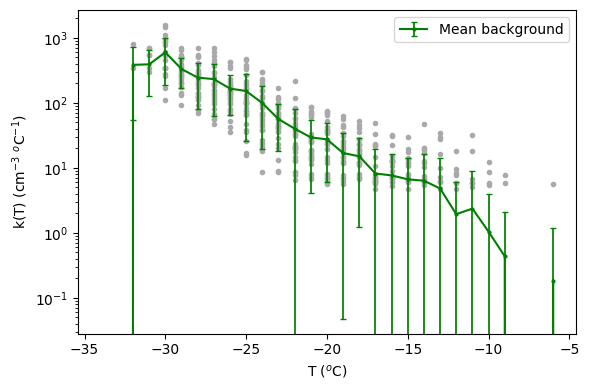

In [10]:
min_T = -35
max_T = -5
dT = 1
T_range = np.arange(min_T, max_T, dT)
background_df, fig, ax = calculate_mean_kT(blanks, T_range)

In [11]:
run_properties={'T_range':T_range,
                'dT':1,
                'v_d':0.002,
                'a_fil':1100,
                'a_fil_err':200,
                'a_drop':1.357,
                'a_drop_err':0.2,
               }

In [24]:
runs

['/home/users/erinraif/acao_data/raw_inp_data/220312/220311_FAAM_C271_RUN1/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220312/220311_FAAM_C271_RUN2/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220314/220311_6_C271_run3/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220316/220316_3_C272_run6/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220320/220319_3_C273_T1_run1/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220320/220319_4_C273_T2_run2/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220322/220321_2_C274_T3_Run3/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220322/220321_4_C274_T1_Run1/temps_auto.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220324/220323_3_C275_T1_run1/temps.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220324/220323_4_C276_T2_run2/temps.csv',
 '/home/users/erinraif/acao_data/raw_inp_data/220325/220323_2_C276_T4_run4/temps.csv',
 '/home/u

In [ ]:
df = pd.read_csv('/home/users/erinraif/acao_data/metadata/filters_reduced_metadata.csv')
flown_runs = df[df['material']=='Teflon']
flown_runs = flown_runs[flown_runs['INP_run_ID'] != 'Blank']
flown_runs = flown_runs[flown_runs['unique_ID'] != 'c276r3t']

flown_runs
nt_dfs = []
for row in flown_runs.itertuples():
    find_csv = [csv for csv in runs if (row.unique_ID[:4] in csv.lower() and 'run'+str(row.INP_run_ID) in csv.lower())]
    run_ID = row.flight_id + '_' + str(row.INP_run_ID)
    nt_df = perform_background_subtraction(background_df, find_csv[0], run_ID, row.integrated_flow,
                                                        run_properties, plot=False)
    nt_dfs.append(nt_df)
all_nts = pd.concat(nt_dfs,axis=1)
all_nts


In [15]:
all_nts = all_nts.sort_index(ascending=False)
#all_nts.to_csv('subtracted_backgrounds_v4_2ul.csv',na_rep='NaN')

In [16]:
def inp_plot(ax, filters_data):
    """
    Plot INP concentration curve on an axis, along with all other INP concentration curves
    in grey for comparison.

    Parameters
    ----------
    ax: matplotlib axes
        axes to plot on
    filters_data: pandas dataframe
        dataframe containing background-subtracted data

    Returns
    -------
    matplotlib axes
        axes with INP plot on

    """
    # Plot specific filter
    temps = filters_data.index
    data = filters_data[filters_data.columns[pd.Series(
        filters_data.columns).str.endswith('NT')]]
    
    errors = filters_data[filters_data.columns[pd.Series(
        filters_data.columns).str.endswith('err')]]

    for i, column in enumerate(data):
        ax.errorbar(temps, data[column], yerr = errors[column[:-2] + 'err'], marker='o',
                    markersize=2, color='gray', capsize=1, elinewidth=0.625, linewidth=0)
    ax.set_yscale('log')
    ax.set_xlim(-35, 0)
    ax.set_ylim(12**-2, 10**2)
    ax.set_xlabel('Temperature / \u00b0C')
    ax.set_ylabel('INP concentration / L\u207b\u00b9')
    ax.grid()
    return ax

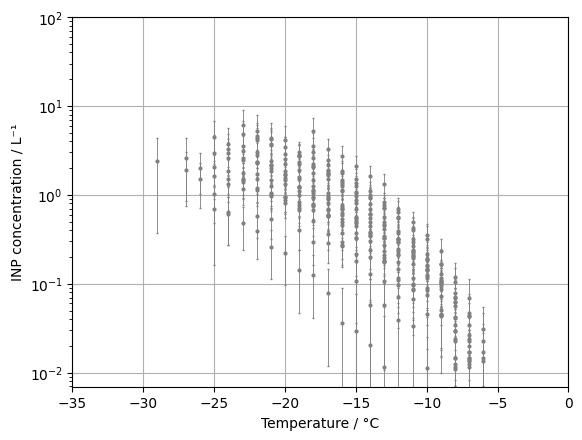

In [17]:
filters_data = pd.read_csv('/home/users/erinraif/acao_data/inp_data/subtracted_backgrounds_v4_2ul.csv',index_col='temp_bin')
fig, ax = plt.subplots()
ax = inp_plot(ax, filters_data)

## Quick look at backgrounds

In [18]:
def get_dates_with_blanks(dates):
    """Function only for playing about with quick-looks.
    """
    dates_with_blanks = []
    for d in dates:
        blanks_this_day = []
        for b in blanks:
            if d in b:
                blanks_this_day.append(b)
        if len(blanks_this_day) > 0:
            dates_with_blanks.append(d)
    return dates_with_blanks

Text(0, 0.5, 'Fraction of droplets on filter frozen')

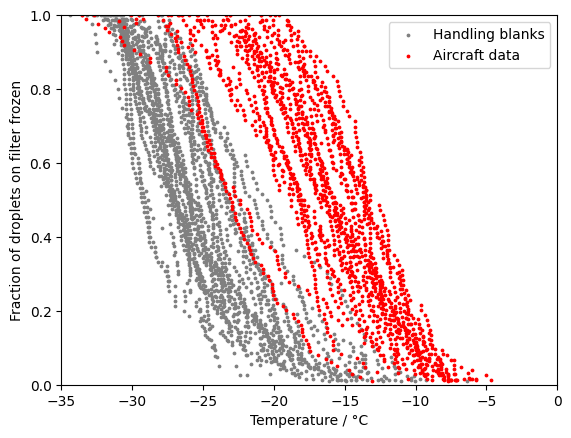

In [21]:
fig, ax = plt.subplots()
label = True
for b in blanks:
    temps, ffs = fraction_frozen(b)
    if label:
        ax.scatter(temps, ffs, color='gray', s=3, label='Handling blanks')
        label=False
    else:
        ax.scatter(temps, ffs, color='gray', s=3)
label = True
for r in runs:
    temps, ffs = fraction_frozen(r)
    if label:
        ax.scatter(temps, ffs, color='red', s=3, label='Aircraft data')
        label=False
    else:
        ax.scatter(temps, ffs, color='red', s=3)
ax.set_xlim(-35,0)
ax.set_ylim(0,1)
ax.legend()
ax.set_xlabel('Temperature / \u00b0C')
ax.set_ylabel('Fraction of droplets on filter frozen')